In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
from pipeline.utils import read_json, make_folder

# EXP 3: Comparing MultiCC to multi-model under various degrees of errors

## Read results from disc

In [3]:
datasets = ['adult', 'german', 'compas', 'cardio', 'bank', 'meps16', 'lawgpa', 'credit', 'UFRGS']
y_cols = ['Income Binary', 'credit', 'two_year_recid'] + ['Y' for i in range(6)]
sensi_cols = ['sex', 'age', 'race'] + ['C0' for i in range(6)]

seeds = [1, 12345, 6, 2211, 15, 88, 121, 433, 500, 1121, 50, 583, 5278, 100000, 0xbeef, 0xcafe, 0xdead, 0xdeadcafe, 0xdeadbeef, 0xbeefcafe]

In [ ]:
# extracting results from MultiCC and multi-model over errorneous data
exp_setting = 'Multi_eval'

datasets = ['lawgpa', 'meps16']
errors_k = [x / 100 for x in range(10, 40)]

res_path = 'intermediate/models/'
group_eval_metrics = ['AUC', 'ACC', 'SR', 'BalAcc']
overall_metrics = ['BalAcc', 'DI', 'EQDiff', 'AvgOddsDiff', 'SPDiff']
settings = ['A', 'E', 'F']

eval_path = 'intermediate/evals/'

eval_file = exp_setting+'_errors_data'+str(len(datasets))+'_n'+str(len(seeds))+'.csv'


all_eval_files = list(filter(lambda x: not os.path.isdir(os.path.join(eval_path, x)), os.listdir(eval_path)))
if not eval_file in all_eval_files:
    multi_df = pd.DataFrame(columns=['data', 'seed', 'error', 'setting', 'group', 'metric', 'value'])
    for error_i in errors_k: 
        exp_suffix = 'error{:.2f}'.format(error_i)
        for data_name in datasets:
            for seed in seeds:
                eval_res = read_json(res_path+data_name+'/'+'-'.join([exp_setting, str(seed), exp_suffix]))
                for setting in settings:
                    for group in ['all', 'G0', 'G1']:
                        base = [data_name, seed, error_i, setting, group]
                        for metric_i in group_eval_metrics:
                            multi_df.loc[multi_df.shape[0]] = base + [metric_i, eval_res[setting][group][metric_i]]
                    for metric_i in overall_metrics:
                        multi_df.loc[multi_df.shape[0]] = [data_name, seed, error_i, setting, 'all'] + [metric_i, eval_res[setting]['all'][metric_i]]

    multi_df.to_csv(eval_path+eval_file, index=False)
    print('Save evaluation results at {}'.format(eval_path+eval_file))
else:
    multi_df = pd.read_csv(eval_path+eval_file)
    print('Read evaluation results from {}'.format(eval_path+eval_file))
    

In [6]:
multi_df.head()

,data,seed,error,setting,group,metric,value
0,lawgpa,1,0.1,A,all,AUC,0.588000
1,lawgpa,1,0.1,A,all,ACC,0.582000
2,lawgpa,1,0.1,A,all,SR,0.418556
3,lawgpa,1,0.1,A,all,BalAcc,0.587987
4,lawgpa,1,0.1,A,G0,AUC,0.491000


In [8]:
# for visualization change the values to be consistent with the order that higher is better
def normalize_fairness_measures(x):
    if x.iloc[0] in ['EQDiff', 'AvgOddsDiff', 'SPDiff']: # difference change to 1-abs(x)
        return 1-abs(x.iloc[1])
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return min(x.iloc[1], 1/x.iloc[1])
        else:
            return x.iloc[1]
    else:# other metrics
        return x.iloc[1]
def add_vis_flag(x):
    if x.iloc[0] in ['EQDiff', 'AvgOddsDiff', 'SPDiff']: # difference change to 1-abs(x)
        if x.iloc[1] < 0: 
            return 0
        else: # G0 has better outcome
            return 1
    
    elif x.iloc[0] == 'DI':
        if x.iloc[1] > 1:
            return 1
        else:
            return 0
    else:# other metrics
        return 0


In [9]:
multi_df['norm_value'] = multi_df[['metric', 'value']].apply(lambda x: normalize_fairness_measures(x), axis=1)
multi_df['norm_flag'] = multi_df[['metric', 'value']].apply(lambda x: add_vis_flag(x), axis=1)

multi_df['setting'] = multi_df['setting'].replace({'A': 'no intervention', 'E': 'multi-model', 'F': 'MultiCC'})
multi_df.head()

,data,seed,error,setting,group,metric,value,norm_value,norm_flag
0,lawgpa,1,0.1,no intervention,all,AUC,0.588000,0.588000,0
1,lawgpa,1,0.1,no intervention,all,ACC,0.582000,0.582000,0
2,lawgpa,1,0.1,no intervention,all,SR,0.418556,0.418556,0
3,lawgpa,1,0.1,no intervention,all,BalAcc,0.587987,0.587987,0
4,lawgpa,1,0.1,no intervention,G0,AUC,0.491000,0.491000,0


## Draw scatter plot

In [23]:
def scatter_plots(df, vis_dataset, vis_metric, vis_settings, 
              legend_names=None, font_label=26, font_legend=18, 
              colors=['#fffacd', '#3cb371'], bg_color = '#f3f3f3', marks=['^', 's'],
              x_ticks=None, y_label=None, x_label=None, legend=True, legend_col=2, save_to_disc=True, 
              plot_path = 'intermediate/evals/plots/'):

    
    fig, ax = plt.subplots(1, figsize=(10, 4), dpi=200)
    input_df = df.copy()
    
    vis_df = input_df[(input_df['data']==vis_dataset) & (input_df['metric']==vis_metric) & (input_df['group']=='all')]
    
    for setting_i, color_i, mark_i in zip(vis_settings, colors, marks):
        for x_i in x_ticks:
            x_df = vis_df[(vis_df['setting']==setting_i) & (vis_df['error']==x_i)]
            y_values = np.array(x_df['norm_value'])
            n_reverse = sum(np.array(x_df['norm_flag']))
            if n_reverse > int(len(y_values) * 0.7): # majoirty of cases in which G0 has better outcomes
                edge_color = 'red'
            else:
                edge_color = 'black'
            ax.scatter(x_i, np.mean(y_values), color=color_i, marker=mark_i, edgecolors=edge_color, s=95)

    if legend_names:
        legends = legend_names
    else:
        legends = vis_settings
    for setting_i, color_i, mark_i, legend_i in zip(vis_settings, colors, marks, legends):
        ax.scatter(-2, -1, color=color_i, marker=mark_i, s=85, edgecolors='black', label=legend_i)
 
    
    ax.set_facecolor(bg_color)
    ax.yaxis.grid(True)
    
    plt.xlim([0.09, max(x_ticks)+0.01])
    plt.xticks([x / 100 for x in range(10, 40) if x%5==0], fontsize=font_label)
    
    plt.ylim([0.0, 1.0])
    plt.yticks(fontsize=font_label);

    if y_label:
        plt.ylabel(y_label, fontsize=font_label)

    if x_label:
        plt.xlabel(x_label, fontsize=font_label)

    if legend:
        plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower center", mode="expand", ncol=legend_col, frameon=False, borderaxespad=0, handlelength=0.9, handletextpad=0.3, fontsize=font_label-7)

    if save_to_disc:
        plt.savefig(plot_path+vis_dataset+'_'+vis_metric+'.pdf', bbox_inches="tight")
    print('Scatter plot is saved at ', plot_path+vis_dataset+'_'+vis_metric+'.pdf')

Scatter plot is saved at  intermediate/evals/plots/exp3/meps16_BalAcc.pdf


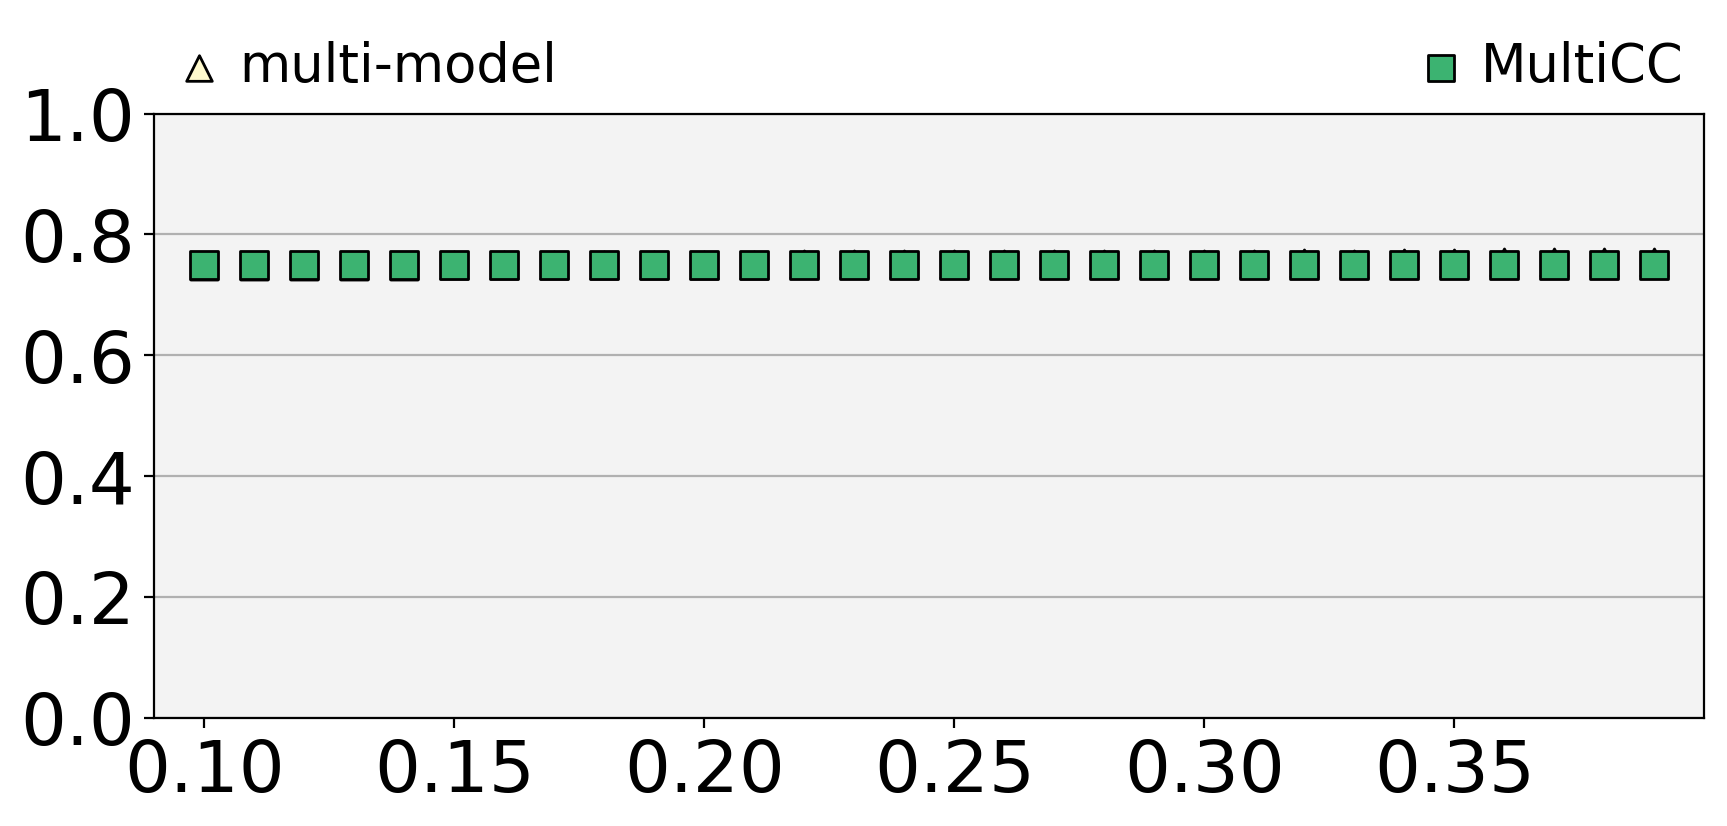

In [28]:
plot_path = 'intermediate/evals/plots/'
exp_name = 'exp3'
# initiate a new folder for the plots
exp_path = plot_path+exp_name+'/'
make_folder(exp_path)



exp_settings = ['multi-model', 'MultiCC']

exp_name = 'meps16' # 'lawgpa'
exp_ticks = [x / 100 for x in range(10, 40)]

exp_metric = 'BalAcc'
scatter_plots(multi_df, exp_name, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


Scatter plot is saved at  intermediate/evals/plots/exp3/meps16_DI.pdf


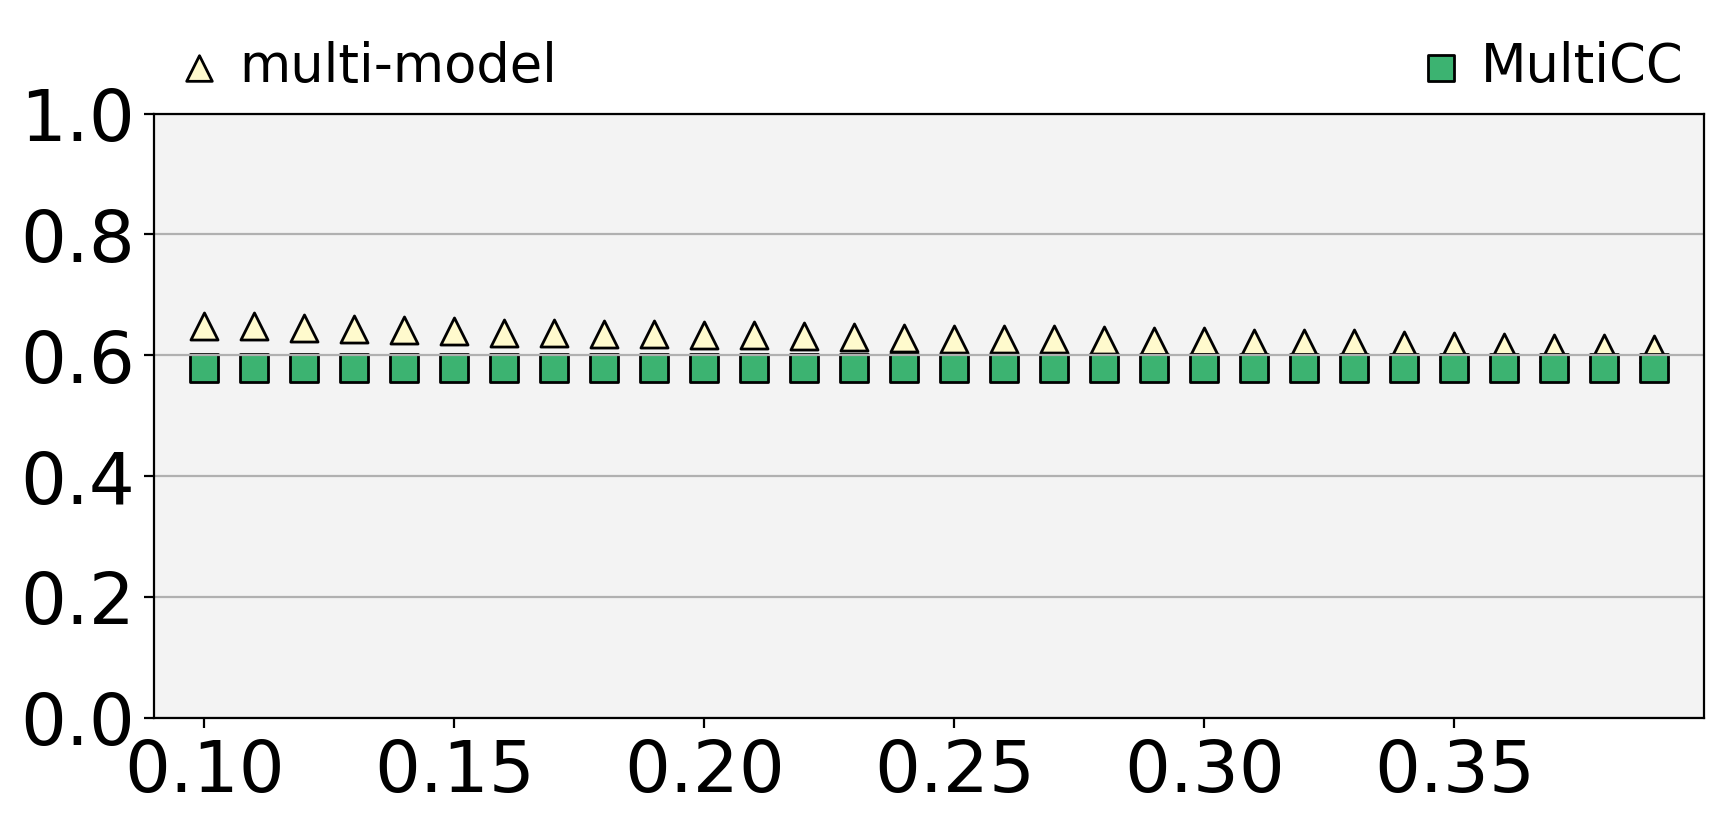

In [29]:
exp_metric = 'DI'
scatter_plots(multi_df, exp_name, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


Scatter plot is saved at  intermediate/evals/plots/exp3/meps16_SPDiff.pdf


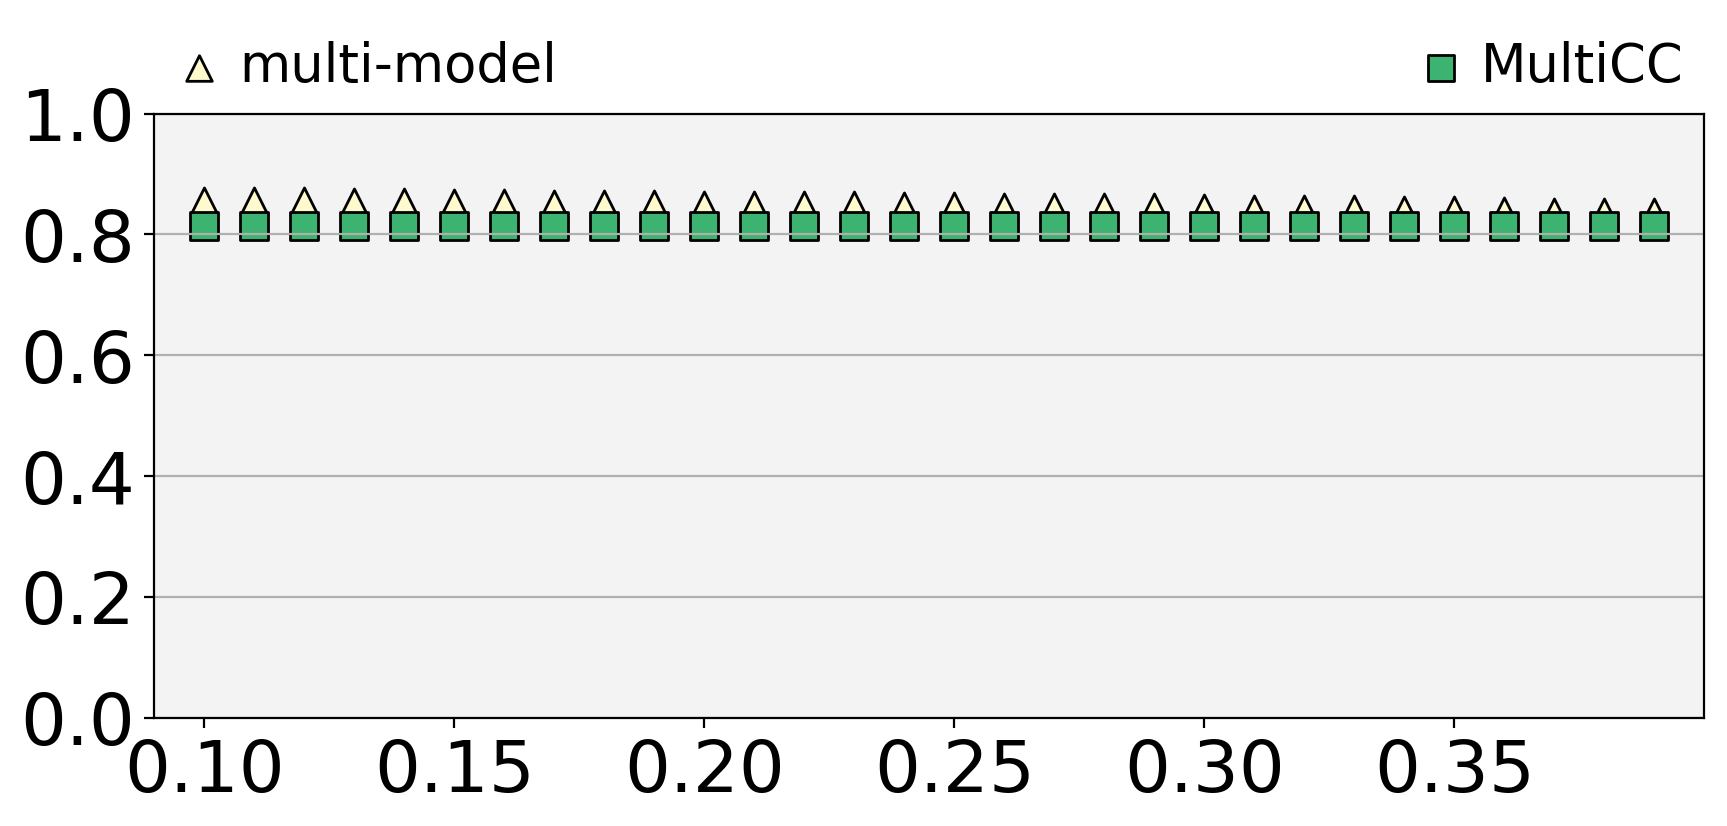

In [30]:
exp_metric = 'SPDiff'
scatter_plots(multi_df, exp_name, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)


Scatter plot is saved at  intermediate/evals/plots/exp3/meps16_AvgOddsDiff.pdf


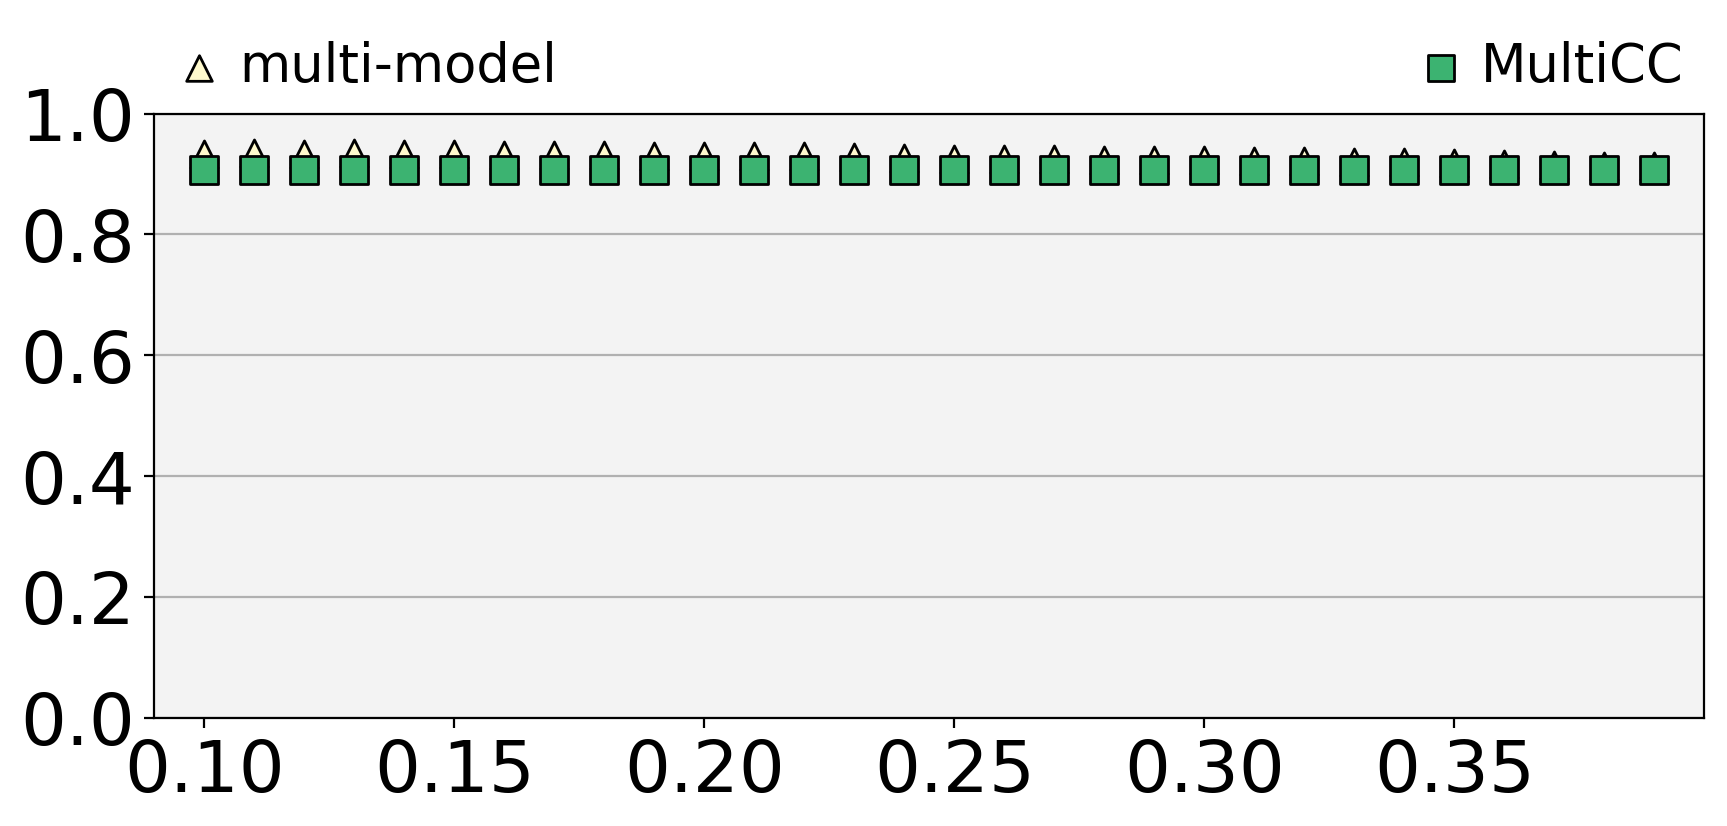

In [31]:
exp_metric = 'AvgOddsDiff'
scatter_plots(multi_df, exp_name, exp_metric, exp_settings, x_ticks=exp_ticks, plot_path=exp_path)
